In [2]:
# Tonic packages
import tonic
from tonic import DiskCachedDataset
import tonic.transforms as tonic_tf

# PyTorch packages
import torch
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader 
from torchvision.transforms import v2

# SNN PyTorch extension packages
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils

# Visualization packages
from IPython.display import HTML 
import matplotlib.pyplot as plt
import seaborn as sns

# Other packages
import numpy as np
import scipy.io as scio
import os, time
import pandas as pd
import asl_dvs
from typing import Any, Callable, Optional, Tuple

# Load Dataset

In [3]:
trainset = asl_dvs.ASLDVS(data_path="../data", train=True)

In [4]:
events, target = trainset[0]
print(events)
print(target)

[( 57, 103,       0, 0) (187, 110,      17, 1) (161, 119,      28, 1) ...
 ( 88, 145, 2999876, 0) ( 76, 134, 2999959, 0) (127, 132, 2999962, 0)]
0


/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_22406/305858719.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tonic.utils.plot_event_grid(events)


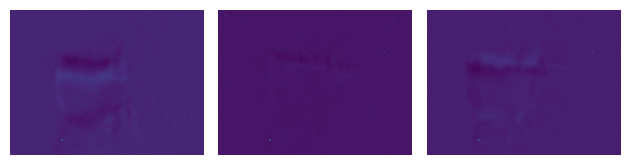

In [5]:
tonic.utils.plot_event_grid(events)

In [6]:

sensor_size = (240, 180, 2)

# Denoise removes isolated, one-off events
# time_window
frame_transform = tonic_tf.Compose([v2.Resize(34), 
                                    tonic_tf.Denoise(filter_time=10000), 
                                    tonic_tf.ToFrame(sensor_size=sensor_size, time_window=1000),
                                    ])


trainset = asl_dvs.ASLDVS(data_path="../data", train=True, transform=frame_transform)
validset = asl_dvs.ASLDVS(data_path="../data", train=False, transform=frame_transform)

In [11]:
events, target = trainset[0]
print(events.shape)
print("Trainset size:", len(trainset))
print("Validationset size: ", len(validset))

(2999, 2, 180, 240)
Trainset size: 496
Validationset size:  214


In [14]:


import torch
import torchvision
from torch.utils.data import DataLoader

batch_size = 5
trainloader = DataLoader(trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

event_tensor, target = next(iter(trainloader))

print(event_tensor.shape)



torch.Size([2999, 5, 2, 180, 240])


## CSNN Model Architecture

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network, 12 filters Conv 5X5-Max Pool 2X2-32 filters Conv 5X5-Max Pool 2X2-800 fully connected 10 o/p
net = nn.Sequential(
                    # 1st layer
                    nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    # 2nd layer
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    # 3rd Layer
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-2) # Adam optimizer
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2) # Mean Square Count Loss

In [ ]:
def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(data.size(0)):  # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

In [ ]:
num_epochs = 1
num_iters = 200

In [ ]:
loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        if i == num_iters:
          break